In [48]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip

import math
import torch
# import shash
from shash.shash_torch import Shash
#import matplotlib.colors as mcolorsxx|

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
from databuilder.data_generator import multi_input_data_organizer
from databuilder.data_generator import ClimateData
import databuilder.data_generator as data_generator
from utils.filemethods import open_data_file as open_data_file
from databuilder.data_loader import universaldataloader
import analysis.analysis_metrics as analysis_metrics
from analysis.analysis_metrics import load_pickle
from utils.utils import get_config
import matplotlib.cm as cm
from analysis.analysis_metrics import maximum_difference

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


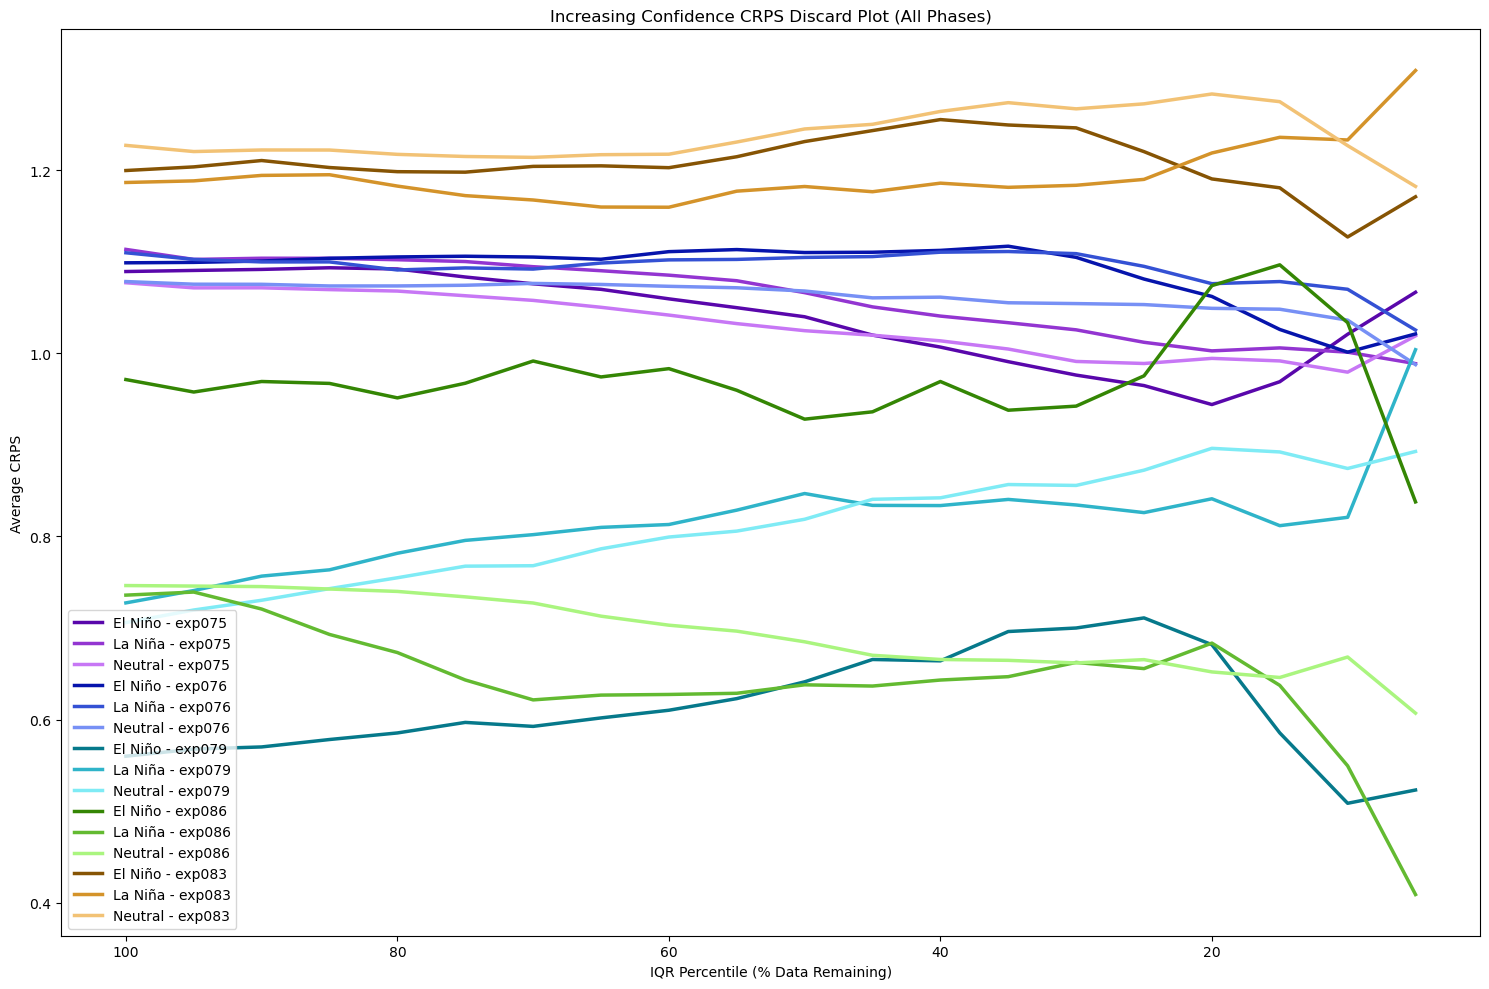

In [49]:
# Open discard plot data from appropriate experiments: 
E3SM_cnn_E3SM_exp = "exp075"
E3SM_snn_E3SM_exp = "exp076"
OBS_cnn_OBS_exp = "exp079"
OBS_snn_OBS_exp = "exp086"
OBS_cnn_E3SM_exp = "exp083"

plt.figure(figsize=(15, 10))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

exps = [E3SM_cnn_E3SM_exp, E3SM_snn_E3SM_exp, OBS_cnn_OBS_exp, OBS_snn_OBS_exp, OBS_cnn_E3SM_exp]
color_themes = {
    0: ["#5907AB", "#9335D1", "#C777F5"], 
    1:[ "#0614AC", "#3451D4", "#7790F5"],
    2: ["#06798B", "#2FB4C9", "#7FEBF5"],
    3: ['#348604', '#63BA31', '#AAF57F'],
    4: ['#865404', '#D4932A', '#F2C275'],
    5: ['#890730', '#D03F6D', '#F484A7']
}
for iexp, experiment_name in enumerate(exps):
    filename = str("/pscratch/sd/p/plutzner/E3SM/saved/output/" + str(experiment_name) + "/" + str(experiment_name) + "_combined_ENSO_IQR_discard_data.pkl")
    try:
        with open(filename, 'rb') as f:
            discard_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError, UnicodeDecodeError):
        try:
            # If it fails, try gzip
            with gzip.open(filename, 'rb') as f:
                discard_data = pickle.load(f)
        except Exception as e:
            raise RuntimeError(f"Failed to load file with both normal and gzip methods: {e}")

    percentile_dict = discard_data['percentiles']
    crps_dict = discard_data['crps']

    plt.plot(percentile_dict['EN'], crps_dict['EN'], label=f'El Niño - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][0])
    plt.plot(percentile_dict['LN'], crps_dict['LN'], label=f'La Niña - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][1])
    plt.plot(percentile_dict['NE'], crps_dict['NE'], label=f'Neutral - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][2])

    plt.xlabel('IQR Percentile (% Data Remaining)')
    plt.ylabel('Average CRPS')
    plt.title('Increasing Confidence CRPS Discard Plot (All Phases)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_discard_plot_combined.png', format = 'png',  dpi = 250)

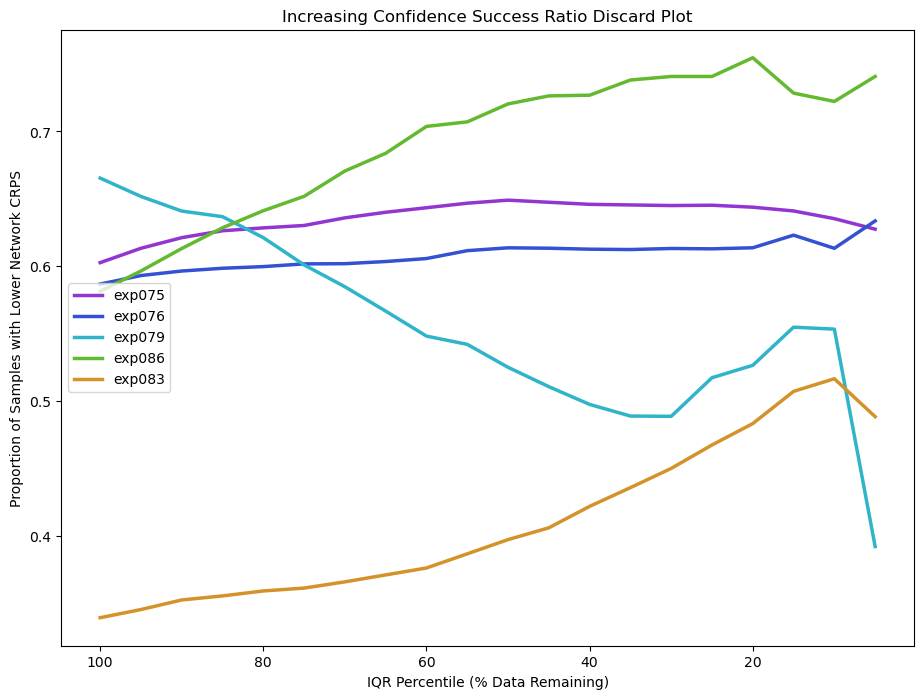

In [50]:
# Open discard plot data from appropriate experiments: 
E3SM_cnn_E3SM_exp = "exp075"
E3SM_snn_E3SM_exp = "exp076"
OBS_cnn_OBS_exp = "exp079"
OBS_snn_OBS_exp = "exp086"
OBS_cnn_E3SM_exp = "exp083"

plt.figure(figsize=(11, 8))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

exps = [E3SM_cnn_E3SM_exp, E3SM_snn_E3SM_exp, OBS_cnn_OBS_exp, OBS_snn_OBS_exp, OBS_cnn_E3SM_exp]
color_themes = {
    0:  "#9335D1", 
    1:  "#3451D4",
    2:  "#2FB4C9",
    3:  '#63BA31',
    4:  '#D4932A',
    5:  '#D03F6D'
}
for iexp, experiment_name in enumerate(exps):
    filename = str("/pscratch/sd/p/plutzner/E3SM/saved/output/" + str(experiment_name) + "/" + str(experiment_name) + "_success_ratio.pkl")
    try:
        with open(filename, 'rb') as f:
            discard_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError, UnicodeDecodeError):
        try:
            # If it fails, try gzip
            with gzip.open(filename, 'rb') as f:
                discard_data = pickle.load(f)
        except Exception as e:
            raise RuntimeError(f"Failed to load file with both normal and gzip methods: {e}")
    
    percentiles = discard_data['percentiles']
    avg_success_ratio = discard_data['avg_success_ratio']

    plt.plot(percentiles, avg_success_ratio, color=color_themes[iexp], label = str(experiment_name), linewidth = 2.5)

    # Place the label near the end of the line
    # x_pos = percentiles[0]
    # y_pos = avg_success_ratio[0]
    # plt.text(x_pos + 0.5, y_pos + 0.012, experiment_name, color=color_themes[iexp], fontsize=11, va='center')

    plt.xlabel('IQR Percentile (% Data Remaining)')
    plt.ylabel('Proportion of Samples with Lower Network CRPS')
    # plt.ylim([min(avg_success_ratio) - 0.2, max(avg_success_ratio) + 0.1])
    plt.title('Increasing Confidence Success Ratio Discard Plot')
    plt.legend(loc = 'center left')
    plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/combined_SuccessRatio_DiscardPlot.png', format = 'png',  dpi = 250) 


### ----------- exp038 vs exp079 COMPARISON --------------

In [51]:
fn_output_E3SM = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp075T_exp083_OOD_INFERENCE_network_SHASH_parameters.pkl'
fn_output_OBS = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp097/exp097_network_SHASH_parameters.pkl'

fn_network_crps_E3SM = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp083_CRPS_network_values.pkl'
fn_network_crps_OBS = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp097/exp097_CRPS_network_values.pkl'

fn_climo_crps_E3SM = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp083_CRPS_climatology_values.pkl'
fn_climo_crps_OBS = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp097/exp097_CRPS_climatology_values.pkl'

fn_target_E3SM = '/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp083_trimmed_test_dat.nc'
fn_target_OBS = '/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp097_trimmed_test_dat.nc'

# open inputs and outputs: 
output_E3SM = load_pickle(fn_output_E3SM)
output_OBS = load_pickle(fn_output_OBS)

network_crps_E3SM = load_pickle(fn_network_crps_E3SM)
network_crps_OBS = load_pickle(fn_network_crps_OBS)

climo_crps_E3SM = load_pickle(fn_climo_crps_E3SM)
climo_crps_OBS = load_pickle(fn_climo_crps_OBS)

# The first half of the target data is actually climatology
# Isolate the years 1981-2023 for the actual predictions
target_E3SM = open_data_file(fn_target_E3SM)
climatology_years = [1940, 1980]
analysis_years = [1981, 2023]
climatology_E3SM = target_E3SM['y'].sel(time=slice(str(climatology_years[0]) + '-01-01', str(climatology_years[1]) + '-12-31'))
target_E3SM = target_E3SM['y'].sel(time=slice(str(analysis_years[0]) + '-01-01', str(analysis_years[1]) + '-12-31'))
# trim output to just the indices corresponding with analysis years
testing_target_time_E3SM = target_E3SM.time.sel(time = slice(str(analysis_years[0]) + '-01-01', str(analysis_years[1]) + '-12-31'))
analysis_years_indices = np.where(np.isin(target_E3SM.time.values, testing_target_time_E3SM.values))[0]
output_E3SM = output_E3SM[analysis_years_indices, ...]
print(f"modified target length: {target_E3SM.shape}")
print(f"climatology length: {climatology_E3SM.shape}")

target_OBS = open_data_file(fn_target_OBS)
print(target_OBS.y)
target_OBS = target_OBS.y
print(f"length of target_OBS = {len(target_OBS)}")
targettime_OBS = target_OBS.time
print(f"target time OBS: {targettime_OBS}")

modified target length: (7822,)
climatology length: (7431,)
<xarray.DataArray 'y' (time: 1037)> Size: 8kB
[1037 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 8kB 2018-02-12 2018-02-13 ... 2023-12-17
length of target_OBS = 1037
target time OBS: <xarray.DataArray 'time' (time: 1037)> Size: 8kB
array(['2018-02-12T00:00:00.000000000', '2018-02-13T00:00:00.000000000',
       '2018-02-14T00:00:00.000000000', ..., '2023-12-15T00:00:00.000000000',
       '2023-12-16T00:00:00.000000000', '2023-12-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8kB 2018-02-12 2018-02-13 ... 2023-12-17
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         valid_time_bnds
    axis:           T


In [52]:
# Isolate overlapping dates of interest from exp038: 
test_start = 2018
test_end = 2023
month_day_start = '-02-12'
month_day_end = '-12-17'

target_E3SM_filtered = target_E3SM.sel(time=slice(str(test_start) + month_day_start, str(test_end) + month_day_end))
targettime_E3SM_filtered = testing_target_time_E3SM.sel(time=slice(str(test_start) + month_day_start, str(test_end) + month_day_end))

matching_times = np.isin(target_E3SM['time'].values, target_E3SM_filtered['time'].values)
E3SM_target_index = np.where(matching_times)[0]
print(f"exp083_target_index = {E3SM_target_index}")
print(f"length of target_index: {len(E3SM_target_index)}")

output_E3SM_filtered = output_E3SM[E3SM_target_index, ...]
network_crps_E3SM_filtered = network_crps_E3SM[E3SM_target_index, ...]
climo_crps_E3SM_filtered = climo_crps_E3SM[E3SM_target_index, ...]


exp083_target_index = [6785 6786 6787 ... 7819 7820 7821]
length of target_index: 1037


In [53]:
# date-for-date, compare CRPS between exp083 and exp079: 
crps_compare1 = 100 * np.sum(network_crps_OBS < network_crps_E3SM_filtered) / len(network_crps_E3SM_filtered)
print(f"Proportion of OBS predictions with lower CRPS than E3SM predictions: {round(crps_compare1, 2)}%")

crps_compare2 = 100 * np.sum(network_crps_E3SM_filtered < network_crps_OBS) / len(network_crps_OBS)
print(f"Proportion of E3SM predictions with lower CRPS than OBS predictions: {round(crps_compare2, 2)}%")

Proportion of OBS predictions with lower CRPS than E3SM predictions: 74.73%
Proportion of E3SM predictions with lower CRPS than OBS predictions: 25.27%


(17574.0, 19708.0)

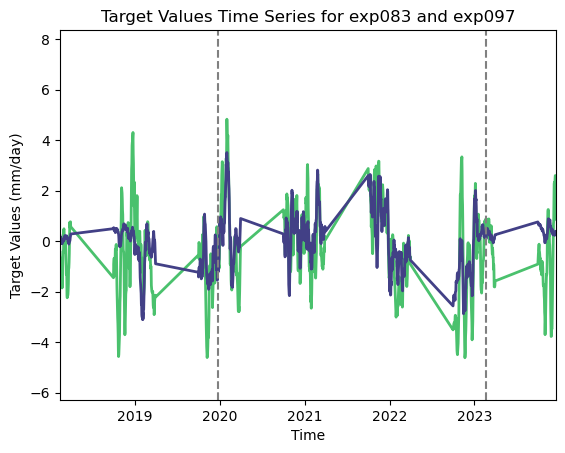

In [61]:
# Plot target value time series: 

plt.figure()
plt.plot(target_E3SM.time, target_E3SM, label='exp083 Target Values', color='#4ac16d', linewidth=2)
plt.plot(target_OBS.time, target_OBS, label='exp097 Target Values', color='#424086', linewidth=2)
plt.axvline(x=select_dates[0], color='gray', linestyle='--', label='Selected Date 1')
plt.axvline(x=select_dates[1], color='gray', linestyle='--', label='Selected Date 2')
plt.xlabel('Time')
plt.ylabel('Target Values (mm/day)')
plt.title('Target Values Time Series for exp083 and exp097')
plt.xlim([target_OBS.time.min(), target_OBS.time.max()])

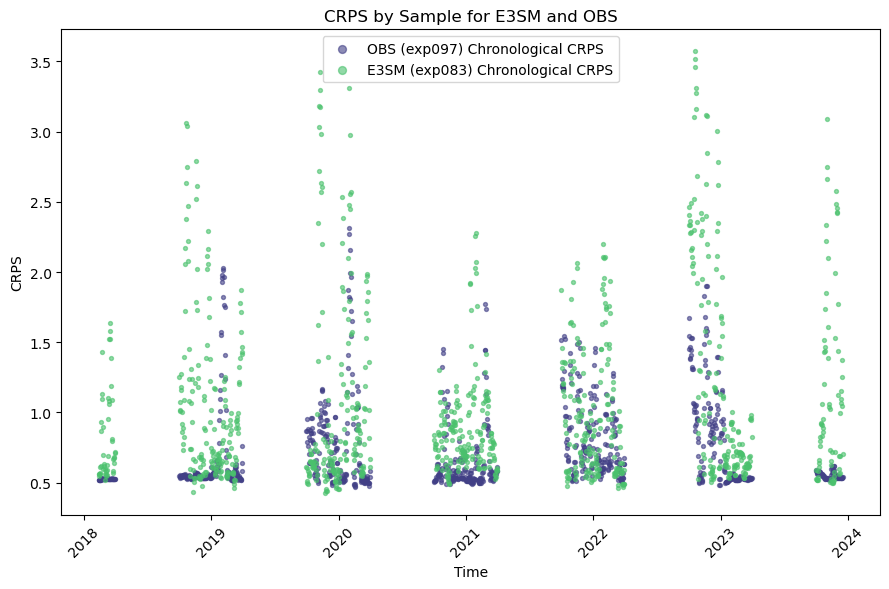

In [54]:
# CPRS by Sample Scatter: 
plt.figure(figsize=(9, 6))
plt.scatter(targettime_OBS, network_crps_OBS, s=8, alpha=0.6, color='#424086', label='OBS (exp097) Chronological CRPS')
plt.scatter(targettime_E3SM_filtered, network_crps_E3SM_filtered, s=8, alpha=0.6, color='#4ac16d', label='E3SM (exp083) Chronological CRPS')
plt.xlabel('Time')
plt.ylabel('CRPS')
plt.title('CRPS by Sample for E3SM and OBS')
plt.legend(markerscale = 2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_by_sample_exp083_exp097.png', format='png', dpi=250)


# Box and whisker plot of the same data binned by 6 month increments: 


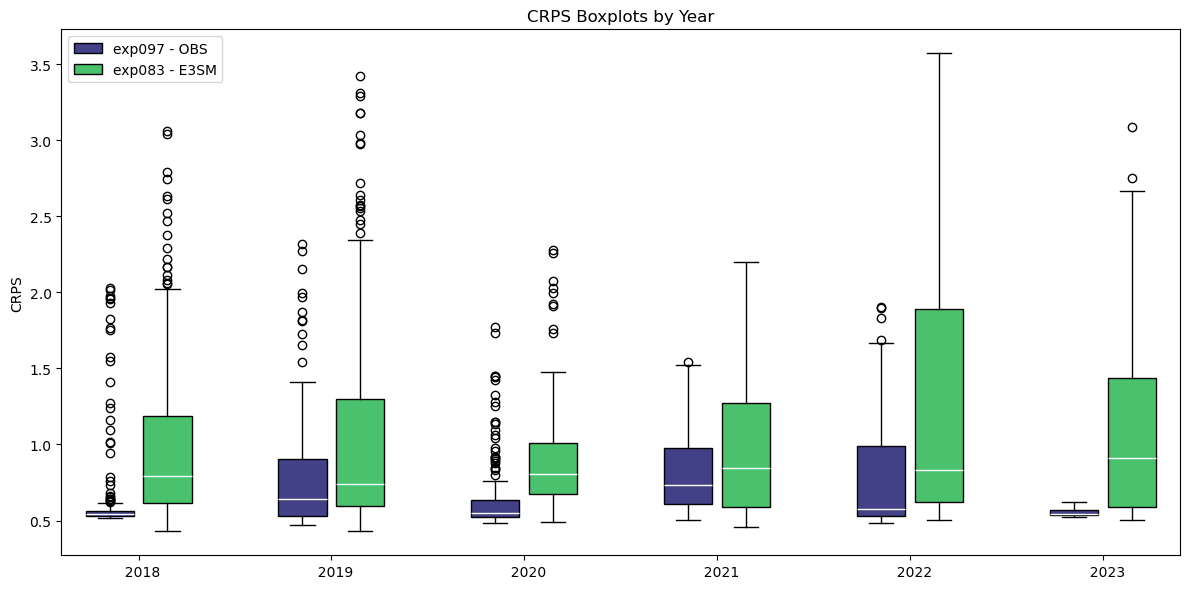

In [55]:
# Define bin edges based on visual cluster breaks
bin_edges = pd.to_datetime([
    "2018-02-12", "2019-10-01", "2020-10-01",
    "2021-10-01", "2022-10-01", "2023-10-01", "2024-10-01"
]).to_numpy()

bin_labels = [f"  {i+2018}" for i in range(len(bin_edges) - 1)]

# Create lists to hold CRPS values for each bin
binned_crps_OBS = []
binned_crps_E3SM = []

# Bin crps_097
for i in range(len(bin_edges) - 1):
    mask = (targettime_OBS >= bin_edges[i]) & (targettime_OBS < bin_edges[i+1])
    binned_crps_OBS.append(network_crps_OBS[mask])

# Bin crps_083
for i in range(len(bin_edges) - 1):
    mask = (targettime_E3SM_filtered >= bin_edges[i]) & (targettime_E3SM_filtered < bin_edges[i+1])
    binned_crps_E3SM.append(network_crps_E3SM_filtered[mask])


fig, ax = plt.subplots(figsize=(12, 6))

# Set positions for side-by-side boxes
positions_OBS = np.arange(len(bin_labels)) * 2.0
positions_E3SM = positions_OBS + 0.6

# Plot
bp1 = ax.boxplot(binned_crps_OBS, positions=positions_OBS, widths=0.5, patch_artist=True,
                 boxprops=dict(facecolor="#424086"), medianprops=dict(color='white'))
bp2 = ax.boxplot(binned_crps_E3SM, positions=positions_E3SM, widths=0.5, patch_artist=True,
                 boxprops=dict(facecolor="#4ac16d"), medianprops=dict(color='white'))

# Set ticks and labels
xtick_positions = (positions_OBS + positions_E3SM) / 2
ax.set_xticks(xtick_positions)
ax.set_xticklabels(bin_labels)
ax.set_ylabel("CRPS")
ax.set_title("CRPS Boxplots by Year")
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["exp097 - OBS", "exp083 - E3SM"], loc="upper left")

plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_boxplot_exp083_exp097.png', format='png', dpi=250)

### SHASH Analysis:

shape of x_values_83 = (1000,)
shape of p83 = (1000, 1037)
shape of x_values_79 = (1000,)
shape of p79 = (1000, 1037)


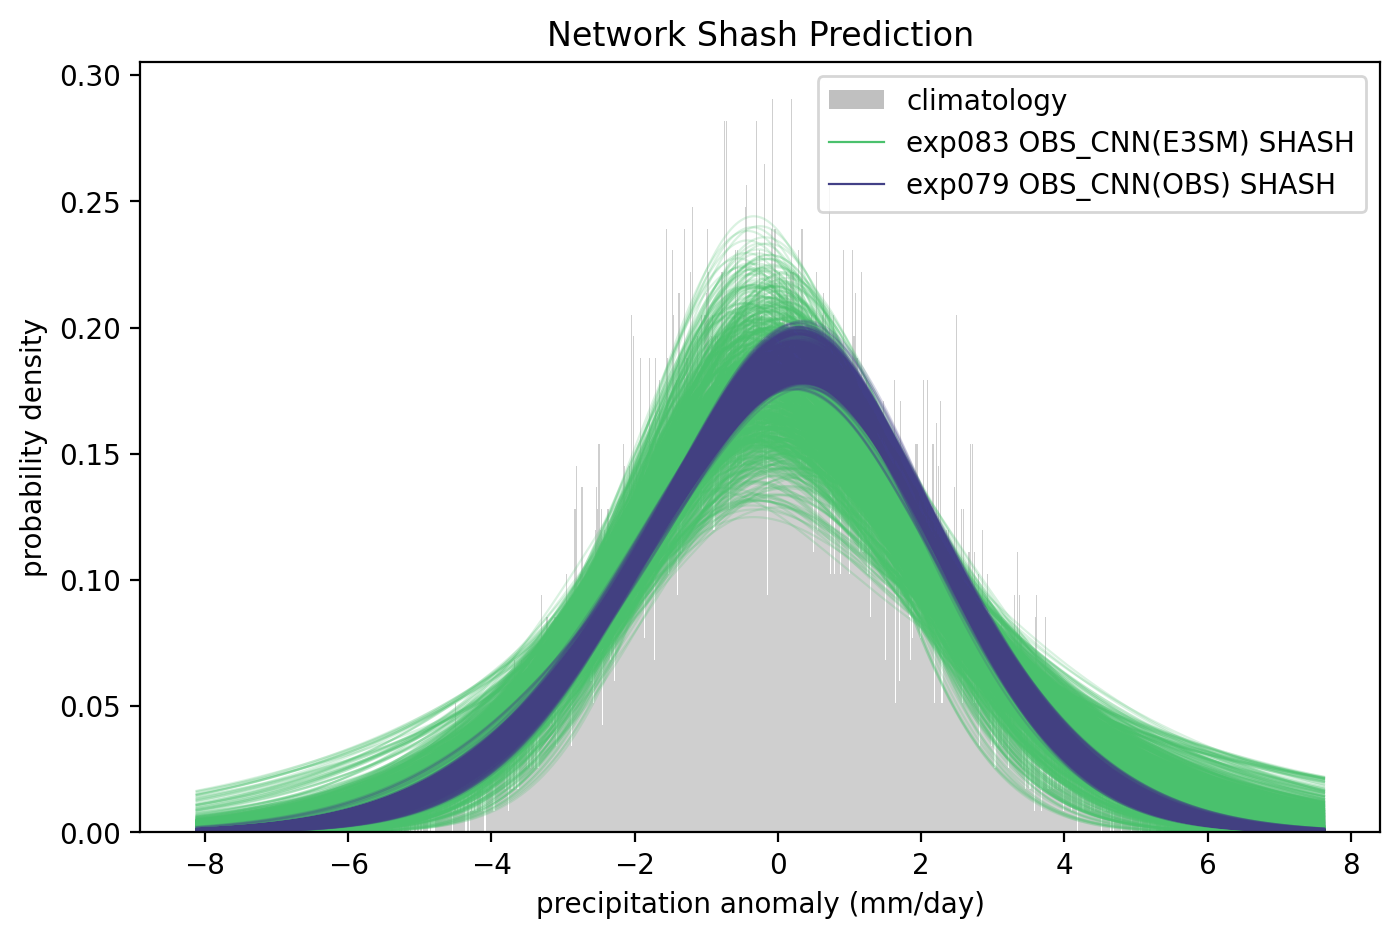

In [56]:
dist_E3SM = Shash(output_E3SM_filtered)
dist_OBS = Shash(output_OBS)

x_values_E3SM = np.linspace(np.min(climatology_E3SM) - 2, np.max(climatology_E3SM), 1000)
x_values_OBS = np.linspace(np.min(climatology_E3SM) - 2, np.max(climatology_E3SM), 1000)

pE3SM = dist_E3SM.prob(x_values_E3SM).numpy()
pOBS = dist_OBS.prob(x_values_OBS).numpy()

plt.figure(figsize=(8, 5), dpi=200)
plt.hist(
    climatology_E3SM, x_values_E3SM, density=True, color="silver", alpha=0.75, label="climatology"
)

print(f"shape of x_values_83 = {x_values_E3SM.shape}")
print(f"shape of p83 = {pE3SM.shape}")
print(f"shape of x_values_79 = {x_values_OBS.shape}")
print(f"shape of p79 = {pOBS.shape}")

plt.plot(x_values_E3SM, pE3SM, linewidth = 0.8, alpha = 0.2, color = "#4ac16d")
plt.plot(x_values_OBS, pOBS, linewidth = 0.8, alpha = 0.2, color = "#424086")
plt.plot(x_values_E3SM[0], pE3SM[0, 0], linewidth = 0.8, alpha = 0.2, label = f"exp083 OBS_CNN(E3SM) SHASH", color = "#4ac16d")
plt.plot(x_values_OBS[0], pOBS[0, 0], linewidth = 0.8, alpha = 0.2, label = f"exp079 OBS_CNN(OBS) SHASH", color = "#424086")
plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
leg = plt.legend(loc = 'upper right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
# plt.ylim([0, 0.375])

plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_exp083_exp097_ALL_testset_samples.png', format='png', dpi=250)

Proportionate variance of mu for exp083 vs exp097: 15.180000305175781
Proportionate variance of sigma for exp083 vs exp097: 21.459999084472656
Proportionate variance of gamma for exp083 vs exp097: 20.6299991607666
Proportionate variance of tau for exp083 vs exp097: 25.889999389648438


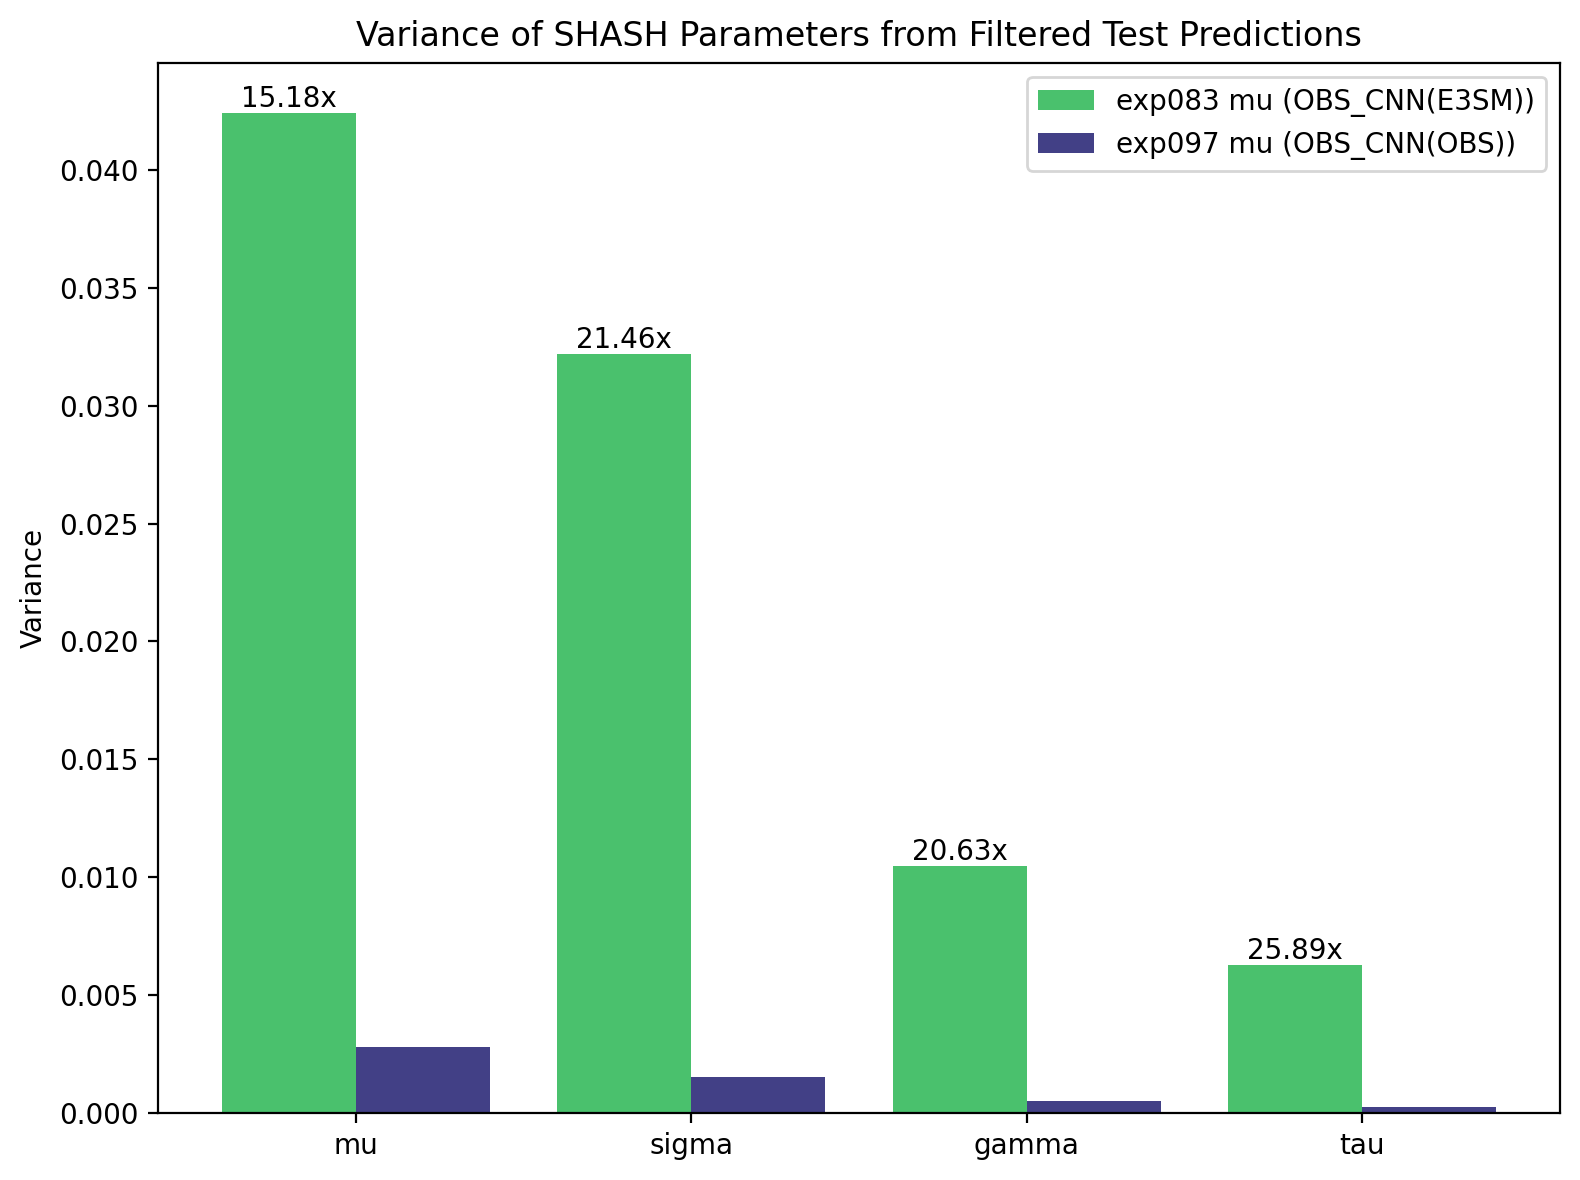

In [57]:
# Variance of shash parameters from filtered test predictions: 
# bar plot for sigma, mu, gamma, tau
cats = ['mu', 'sigma', 'gamma', 'tau']
var_dict = {
    'mu': [np.var(output_E3SM_filtered[:, 0]), np.var(output_OBS[:, 0])],
    'sigma': [np.var(output_E3SM_filtered[:, 1]), np.var(output_OBS[:, 1])],
    'gamma': [np.var(output_E3SM_filtered[:, 2]), np.var(output_OBS[:, 2])],
    'tau': [np.var(output_E3SM_filtered[:, 3]), np.var(output_OBS[:, 3])],
}

plt.figure(figsize=(8, 6), dpi=200)
for i, cat in enumerate(cats):
    plt.bar(i - 0.2, var_dict[cat][0], width=0.4, color='#4ac16d', label=f'exp083 {cat} (OBS_CNN(E3SM))' if i == 0 else "")
    plt.bar(i + 0.2, var_dict[cat][1], width=0.4, color='#424086', label=f'exp097 {cat} (OBS_CNN(OBS))' if i == 0 else "")
    proportionate_var = var_dict[cat][0] / var_dict[cat][1]
    proportionate_var = round(proportionate_var, 2)
    print(f"Proportionate variance of {cat} for exp083 vs exp097: {round(proportionate_var, 2)}")
    plt.text(i - 0.2, var_dict[cat][0], f"{proportionate_var:.2f}x", ha='center', va='bottom', fontsize=10)
plt.xticks(range(len(cats)), cats)
plt.ylabel('Variance')
plt.title('Variance of SHASH Parameters from Filtered Test Predictions')
plt.legend()
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_parameter_variance_exp083_exp097.png', format='png', dpi=250)


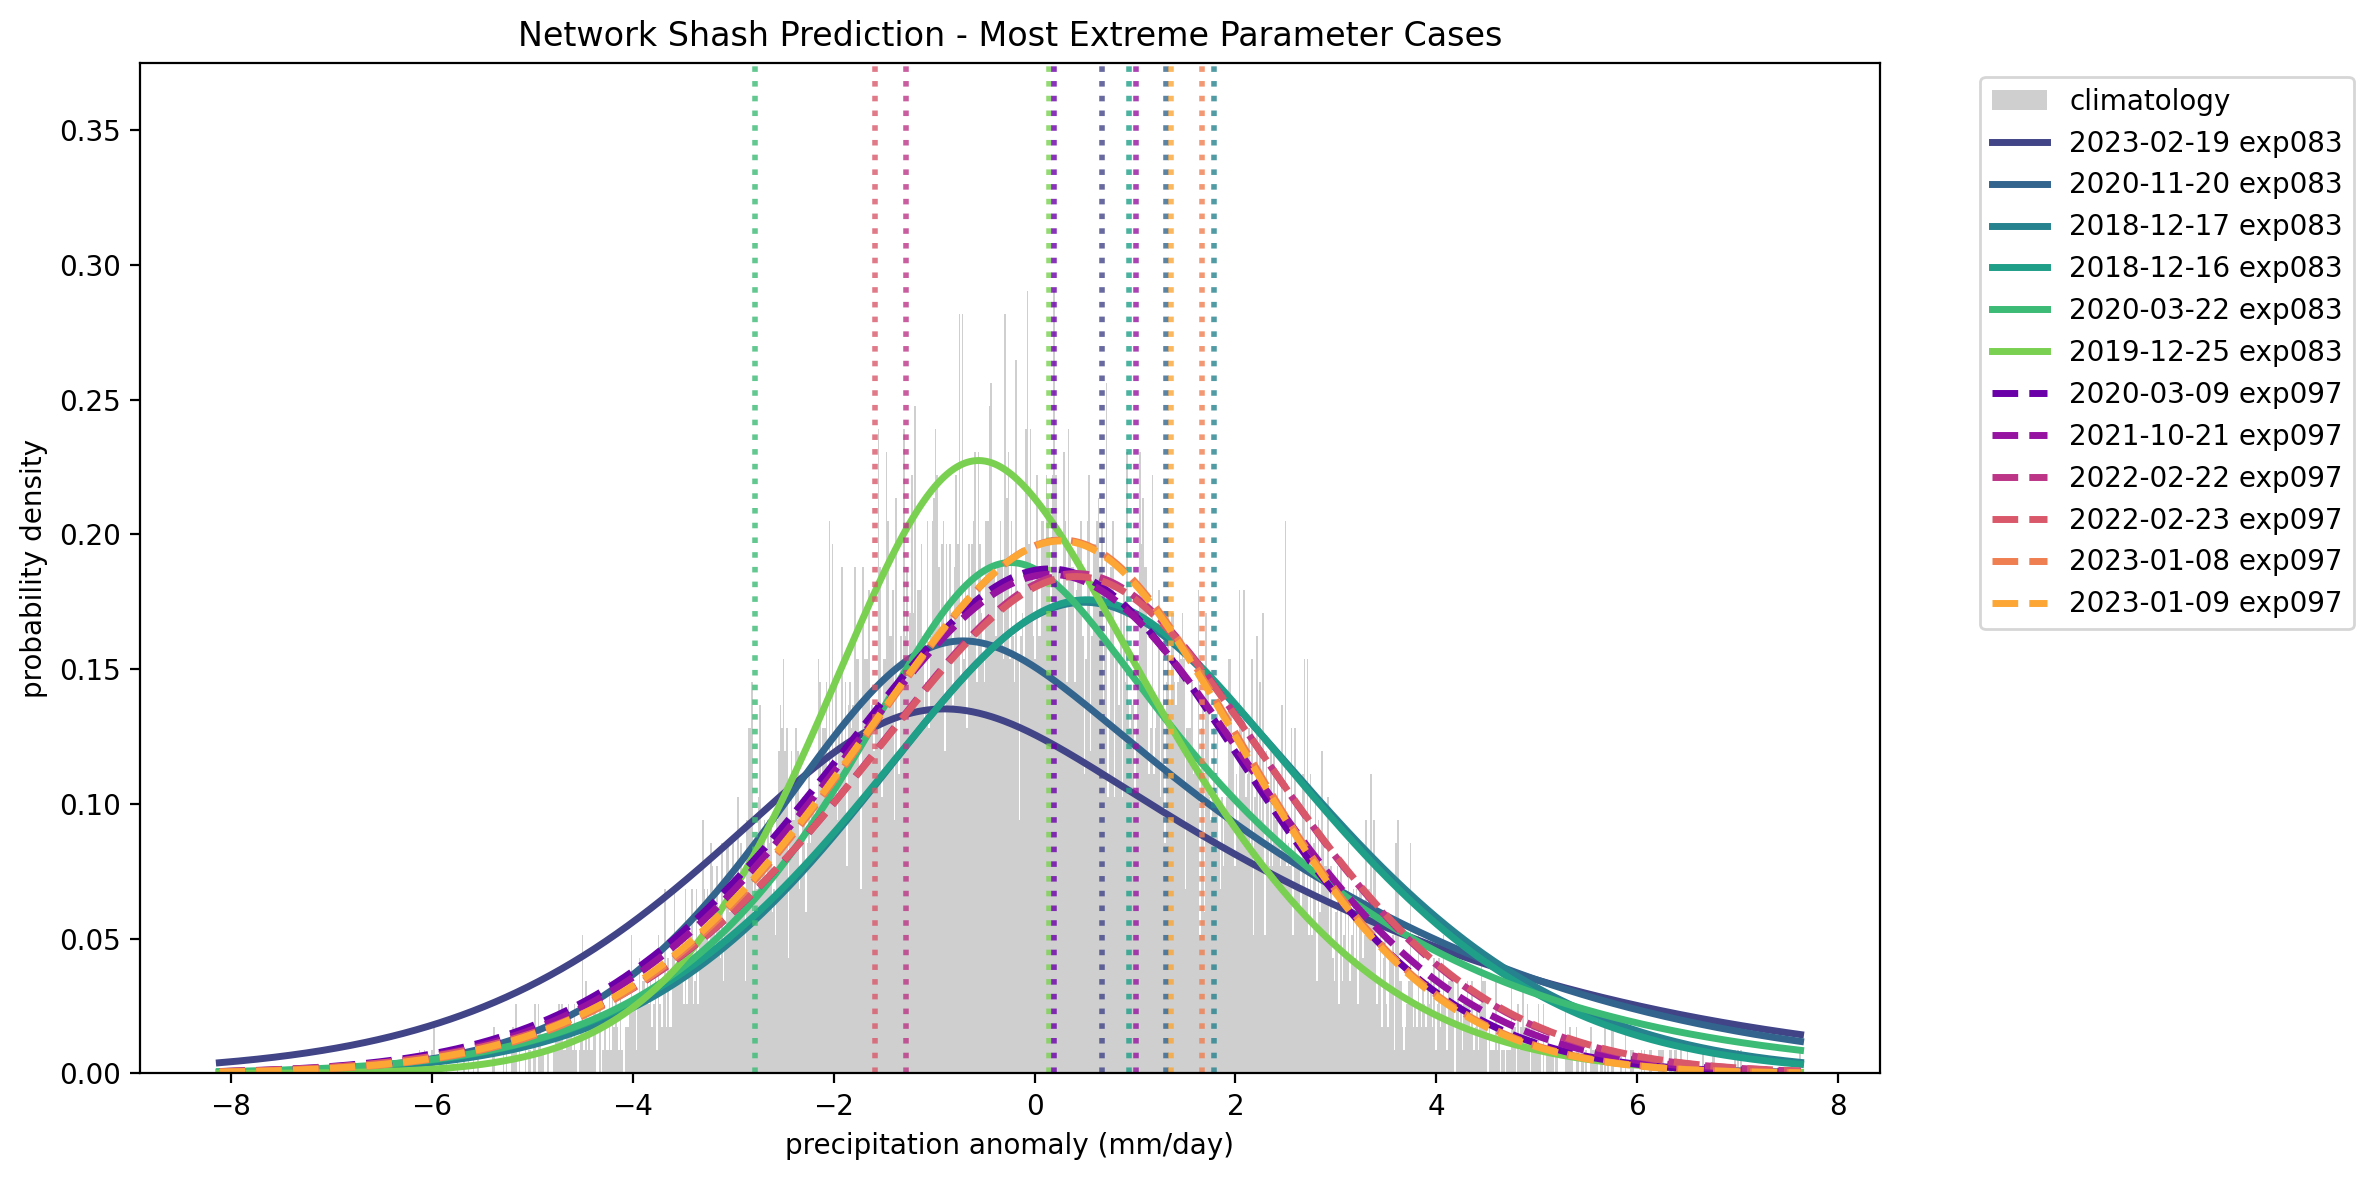

In [58]:

# Isolate dates where sigma and mu parameters are most extreme in magnitude: 
num = 6
extreme_samps_E3SM, extreme_dates_E3SM = maximum_difference(output_E3SM_filtered, target_E3SM_filtered, required_samples = num, tau_frozen=False)
extreme_samps_OBS, extreme_dates_OBS = maximum_difference(output_OBS, target_OBS, required_samples = num, tau_frozen=False)

# Get target values for each experiment separately
true_target_values_E3SM = target_E3SM_filtered.sel(time=extreme_dates_E3SM).values
true_target_values_OBS = target_OBS.sel(time=extreme_dates_OBS).values

# print(f"Target values exp083: {true_target_values_83}")
# print(f"Target values exp079: {true_target_values_79}")

plt.figure(figsize=(12, 6), dpi=200)

# Plot climatology histogram
x_values_E3SM = np.linspace(np.min(climatology_E3SM) - 2, np.max(climatology_E3SM), 1000)
plt.hist(climatology_E3SM, x_values_E3SM, density=True, color="silver", alpha=0.75, label="climatology")

# Get colormaps - use different color ranges for each experiment
colors_E3SM = cm.viridis(np.linspace(0.2, 0.8, num))  # Viridis colors for exp083
colors_OBS = cm.plasma(np.linspace(0.2, 0.8, num))   # Plasma colors for exp079

# Plot exp083 extreme cases
for i in range(num):
    color = colors_E3SM[i]
    date = extreme_dates_E3SM[i]

    # Create distribution
    dist_E3SM = Shash(extreme_samps_E3SM[i:i+1, ...])  # Keep batch dimension

    # Calculate probabilities
    pE3SM = dist_E3SM.prob(x_values_E3SM).numpy()

    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pE3SM, linewidth=2.5, linestyle='-', 
             color=color, label=f"{date_str} exp083")
    
    # Plot vertical line for target value
    plt.axvline(x=true_target_values_E3SM[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

# Plot exp079 extreme cases
for i in range(num):
    color = colors_OBS[i]
    date = extreme_dates_OBS[i]
    
    # Create distribution
    dist_OBS = Shash(extreme_samps_OBS[i:i+1, ...])  # Keep batch dimension
    
    # Calculate probabilities
    pOBS = dist_OBS.prob(x_values_OBS).numpy()  # Use same x_values for both
    
    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pOBS, linewidth=2.5, linestyle='--',
             color=color, label=f"{date_str} exp097")

    # Plot vertical line for target value
    plt.axvline(x=true_target_values_OBS[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction - Most Extreme Parameter Cases")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim([0, 0.375])
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_extreme_cases_exp083_exp097.png', format='png', dpi=250)
plt.show()

# Print the extreme parameter values for reference
# print("\nExtreme Parameter Values:")
# print("="*50)
# param_names = ['mu', 'sigma', 'nu', 'tau']

# print("\nexp083 extreme parameters:")
# for i in range(num):
#     if hasattr(extreme_dates_83[i], 'values'):
#         date_str = pd.to_datetime(extreme_dates_83[i].values).strftime('%Y-%m-%d')
#     else:
#         date_str = pd.to_datetime(extreme_dates_83[i]).strftime('%Y-%m-%d')
#     params = dict(zip(param_names, extreme_samps_83[i, :4]))
#     print(f"  {date_str}: {params}")

# print("\nexp079 extreme parameters:")
# for i in range(num):
#     if hasattr(extreme_dates_79[i], 'values'):
#         date_str = pd.to_datetime(extreme_dates_79[i].values).strftime('%Y-%m-%d')
#     else:
#         date_str = pd.to_datetime(extreme_dates_79[i]).strftime('%Y-%m-%d')
#     params = dict(zip(param_names, extreme_samps_79[i, :4]))
#     print(f"  {date_str}: {params}")


Target values exp083: [0.14349976 0.67011954]
Target values exp079: [-1.0652943   0.13792936]
[Timestamp('2019-12-25 00:00:00'), Timestamp('2023-02-19 00:00:00')]


IndexError: index 2 is out of bounds for axis 0 with size 2

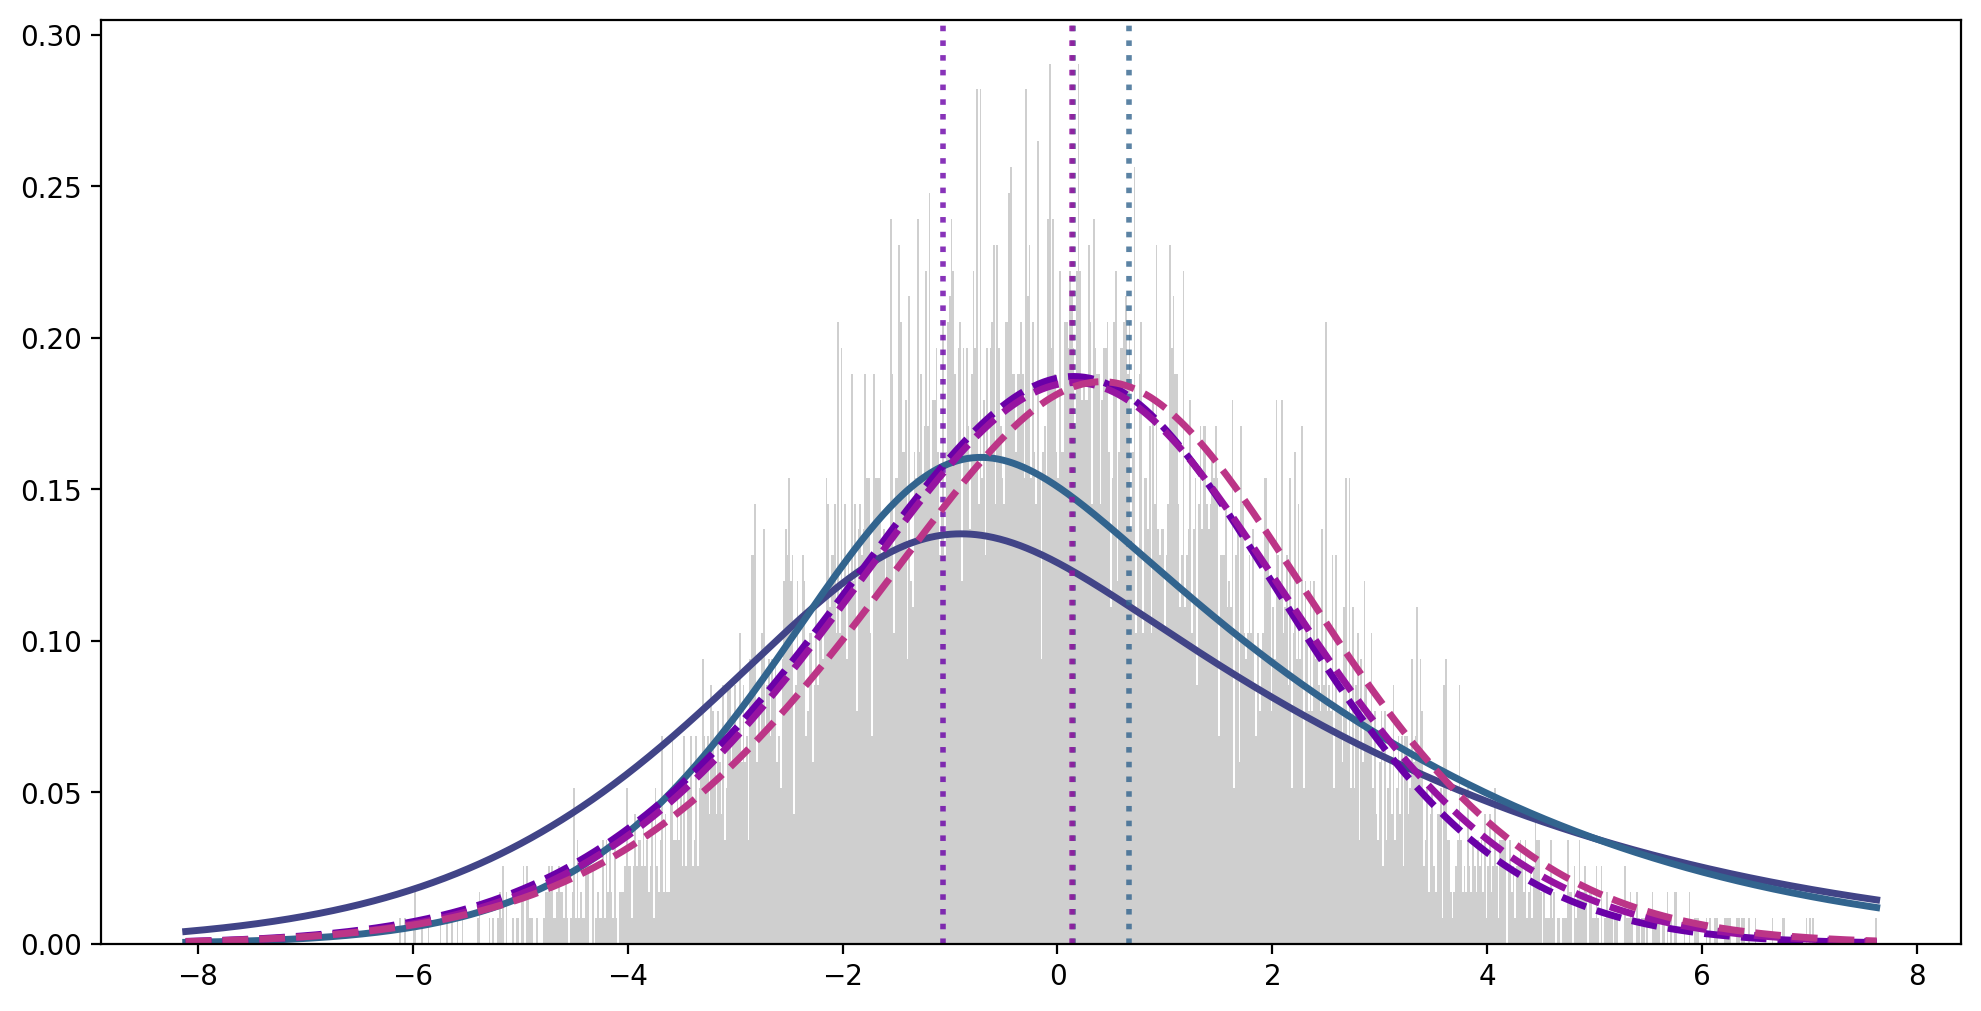

In [59]:
select_dates = [pd.to_datetime('2019-12-25'), pd.to_datetime('2023-02-19')]


# Get target values for each experiment separately
true_target_values_E3SM = target_E3SM_filtered.sel(time=select_dates).values
true_target_values_OBS = target_OBS.sel(time=select_dates).values

print(f"Target values exp083: {true_target_values_E3SM}")
print(f"Target values exp079: {true_target_values_OBS}")
print(select_dates)

# print(f"Target values exp083: {true_target_values_83}")
# print(f"Target values exp079: {true_target_values_79}")

plt.figure(figsize=(12, 6), dpi=200)

# Plot climatology histogram
x_values_83 = np.linspace(np.min(climatology_E3SM) - 2, np.max(climatology_E3SM), 1000)
plt.hist(climatology_E3SM, x_values_E3SM, density=True, color="silver", alpha=0.75, label="climatology")

# Get colormaps - use different color ranges for each experiment
colors_E3SM = cm.viridis(np.linspace(0.2, 0.8, num))  # Viridis colors for exp083
colors_OBS = cm.plasma(np.linspace(0.2, 0.8, num))   # Plasma colors for exp079

# Plot exp083 extreme cases
for i in range(len(select_dates)):
    color = colors_E3SM[i]
    date = extreme_dates_E3SM[i]
    
    # Create distribution
    dist_E3SM = Shash(extreme_samps_E3SM[i:i+1, ...])  # Keep batch dimension

    # Calculate probabilities
    pE3SM = dist_E3SM.prob(x_values_E3SM).numpy()

    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pE3SM, linewidth=2.5, linestyle='-', 
             color=color, label=f"{date_str} exp083")
    
    # Plot vertical line for target value
    plt.axvline(x=true_target_values_E3SM[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

# Plot exp097 extreme cases
for i in range(num):
    color = colors_OBS[i]
    date = extreme_dates_OBS[i]

    # Create distribution
    dist_OBS = Shash(extreme_samps_OBS[i:i+1, ...])  # Keep batch dimension
    # Calculate probabilities
    pOBS = dist_OBS.prob(x_values_OBS).numpy()  # Use same x_values for both

    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pOBS, linewidth=2.5, linestyle='--',
             color=color, label=f"{date_str} exp097")

    # Plot vertical line for target value
    plt.axvline(x=true_target_values_OBS[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction - Most Extreme Parameter Cases")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim([0, 0.375])
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_extreme_cases_exp083_exp097.png', format='png', dpi=250)
plt.show()

### Extreme Precip Probabilities

In [ ]:
# Plot distribution of target values for all test data: 
plt.figure(figsize=(12, 6), dpi=200)
plt.hist(target_OBS, bins=50, density=True, alpha=0.5, color='#4ac16d', label='exp097 Target Values')
plt.hist(target_E3SM, bins=50, density=True, alpha=0.5, color='#424086', label='exp083 Target Values') # SHOULD BE IDENTICAL!!!!!!
plt.xlabel('Target Values (mm/day)')
plt.ylabel('Density')
plt.title('Distribution of Target Values')
plt.legend()
plt.tight_layout()


# Select extreme precip amount: 
extreme_thresh = 3 # mm/day


select_dates = [pd.to_datetime('2019-12-25'), pd.to_datetime('2023-02-19')]


# Get target values for each experiment separately
true_target_values_E3SM = target_E3SM_filtered.sel(time=select_dates).values
true_target_values_OBS = target_OBS.sel(time=select_dates).values

print(f"Target values exp083: {true_target_values_E3SM}")
print(f"Target values exp079: {true_target_values_OBS}")
print(select_dates)

# print(f"Target values exp083: {true_target_values_83}")
# print(f"Target values exp079: {true_target_values_79}")

plt.figure(figsize=(12, 6), dpi=200)

# Plot climatology histogram
x_values_83 = np.linspace(np.min(climatology_E3SM) - 2, np.max(climatology_E3SM), 1000)
plt.hist(climatology_E3SM, x_values_E3SM, density=True, color="silver", alpha=0.75, label="climatology")

# Get colormaps - use different color ranges for each experiment
colors_E3SM = cm.viridis(np.linspace(0.2, 0.8, num))  # Viridis colors for exp083
colors_OBS = cm.plasma(np.linspace(0.2, 0.8, num))   # Plasma colors for exp079

# Plot exp083 extreme cases
for i in range(len(select_dates)):
    color = colors_E3SM[i]
    date = extreme_dates_E3SM[i]
    
    # Create distribution
    dist_E3SM = Shash(extreme_samps_E3SM[i:i+1, ...])  # Keep batch dimension
    
    # Calculate probabilities
    pE3SM = dist_E3SM.prob(x_values_E3SM).numpy()
    
    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pE3SM, linewidth=2.5, linestyle='-',
             color=color, label=f"{date_str} exp083")
    
    # Create mask for values greater than threshold
    mask = x_values_E3SM >= extreme_thresh
    
    # Shade area under curve for values > threshold
    plt.fill_between(x_values_E3SM, 0, pE3SM, 
                    where=mask, 
                    alpha=0.2, 
                    color=color)
    
    # Calculate and print probability above threshold
    prob_above_thresh_E3SM = 1 - dist_E3SM.cdf(extreme_thresh).numpy()[0]
    print(f"exp083 {date_str}: P(X ≥ {extreme_thresh}) = {prob_above_thresh_E3SM:.4f}")
    
    # Plot vertical line for target value
    plt.axvline(x=true_target_values_E3SM[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

# Plot exp097 extreme cases
for i in range(num):
    color = colors_OBS[i]
    date = extreme_dates_OBS[i]
    
    # Create distribution
    dist_OBS = Shash(extreme_samps_OBS[i:i+1, ...])  # Keep batch dimension
    # Calculate probabilities
    pOBS = dist_OBS.prob(x_values_OBS).numpy()  # Use same x_values for both
    
    # Convert xarray DataArray date to string
    if hasattr(date, 'values'):
        date_str = pd.to_datetime(date.values).strftime('%Y-%m-%d')
    else:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    
    # Plot SHASH curve
    plt.plot(x_values_E3SM, pOBS, linewidth=2.5, linestyle='--',
             color=color, label=f"{date_str} exp097")
    
    # Create mask for values greater than threshold
    mask = x_values_E3SM >= extreme_thresh
    
    # Shade area under curve for values > threshold
    plt.fill_between(x_values_E3SM, 0, pOBS, 
                    where=mask, 
                    alpha=0.15, 
                    color=color)
    
    # Calculate and print probability above threshold
    prob_above_thresh_OBS = 1 - dist_OBS.cdf(extreme_thresh).numpy()[0]
    print(f"exp097 {date_str}: P(X ≥ {extreme_thresh}) = {prob_above_thresh_OBS:.4f}")
    
    # Plot vertical line for target value
    plt.axvline(x=true_target_values_OBS[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

# Add vertical line at threshold for reference
plt.axvline(x=extreme_thresh, linestyle='--', color='black', alpha=0.7, linewidth=2, 
           label=f'Threshold: {extreme_thresh} mm/day')

plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction - Most Extreme Parameter Cases")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim([0, 0.375])
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_extreme_cases_exp083_exp097.png', format='png', dpi=250)
plt.show()

In [ ]:
# true_target_values_83 = target_83_filtered.sel(time=dates_83).values
# true_target_values_79 = target_79.sel(time=dates_79).values


# # dates = [date1, date2, date3, date4]
# # # isolate shash params from output_83_filtered and output_79
# # single_predictions_83 = np.zeros([len(dates), 4])
# # single_predictions_79 = np.zeros([len(dates), 4])
# # true_target_values_83 = np.zeros([len(dates), 1])
# # true_target_values_79 = np.zeros([len(dates), 1])   

# # # Prepare data outside the plotting loop
# # for i, date in enumerate(dates):
# #     single_predictions_83[i, ...] = output_83_filtered[targettime_83_filtered == date, ...]
# #     single_predictions_79[i, ...] = output_79[targettime_79 == date, ...]
# #     true_target_values_83[i] = target_83_filtered.sel(time=date).values
# #     true_target_values_79[i] = target_79.sel(time=date)

# # # Prepare data outside the plotting loop
# # for i, date in enumerate(dates):
# #     single_predictions_83[i, ...] = output_83_filtered[targettime_83_filtered == date, ...]
# #     single_predictions_79[i, ...] = output_79[targettime_79 == date, ...]
# #     true_target_values_83[i] = target_83_filtered.sel(time=date).values
# #     true_target_values_79[i] = target_79.sel(time=date)

# plt.figure(figsize=(8, 5), dpi=200)

# # Plot climatology histogram
# x_values_83 = np.linspace(np.min(climatology_83) - 2, np.max(climatology_83), 1000)
# plt.hist(climatology_83, x_values_83, density=True, color="silver", alpha=0.75, label="climatology")


# # Get colormap
# cmap = cm.get_cmap('viridis', len(dates))

# # Plot each date's predictions
# for i, date in enumerate(dates):
#     color = cmap(i)  # Get color for this date
    
#     # Create distributions
#     # dist_83 = Shash(single_predictions_83[i:i+1, ...])  # Keep batch dimension
#     # dist_79 = Shash(single_predictions_79[i:i+1, ...])  # Keep batch dimension
#     dist_83 = Shash(extreme_samps_83[i:i+1, ...])  # Keep batch dimension
#     dist_79 = Shash(extreme_samps_79[i:i+1, ...])  # Keep batch dimension

#     # Calculate probabilities
#     p83 = dist_83.prob(x_values_83).numpy()
#     p79 = dist_79.prob(x_values_83).numpy()  # Use same x_values for both
    
#     # Plot curves and vertical lines with same color
#     date_str = date.strftime('%Y-%m-%d')
    
#     # Plot SHASH curves
#     plt.plot(x_values_83, p83, linewidth=2, linestyle='-', 
#              color=color, label=f"{date_str} exp083")
#     plt.plot(x_values_83, p79, linewidth=2, linestyle='--', 
#              color=color, label=f"{date_str} exp079")
    
#     # Plot vertical lines for target values (same color, no separate legend entries)
#     plt.axvline(x=true_target_values_83[i], linestyle=':', color=color, alpha=0.8, linewidth=2)
#     plt.axvline(x=true_target_values_79[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

# plt.xlabel("precipitation anomaly (mm/day)")
# plt.ylabel("probability density")
# plt.title("Network Shash Prediction")
# plt.legend(loc='upper right')
# plt.ylim([0, 0.375])
# plt.tight_layout()
# plt.show()